In [39]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from scipy.stats import zscore

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor

from sklearn.linear_model import Ridge, RidgeCV, Lasso,LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

from sklearn.utils import resample

# for warnings 
import warnings
warnings.filterwarnings('ignore')




In [40]:
path = 'Processed_data.csv'
df = pd.read_csv(path)
df.head()

,symboling,normalized_losses,make,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,...,peak_rpm,city_mpg,highway_mpg,price,city_L/100km,horsepower-binned,diesel,gas,aspiration_std,aspiration_turbo
0,3,122.0,alfa-romero,two,convertible,rwd,front,88.6,0.811148,0.890278,...,5000.0,21,27,16500,11.190476,Low,0,1,1,0
1,1,122.0,alfa-romero,two,hatchback,rwd,front,94.5,0.822681,0.909722,...,5000.0,19,26,16500,12.368421,Medium,0,1,1,0
2,2,164.0,audi,four,sedan,fwd,front,99.8,0.848630,0.919444,...,5500.0,24,30,13950,9.791667,Low,0,1,1,0
3,2,164.0,audi,four,sedan,4wd,front,99.4,0.848630,0.922222,...,5500.0,18,22,17450,13.055556,Low,0,1,1,0
4,2,161.0,audi,two,sedan,fwd,front,99.8,0.851994,0.920833,...,5500.0,19,25,15250,12.368421,Low,0,1,1,0


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          200 non-null    int64  
 1   normalized_losses  200 non-null    float64
 2   make               200 non-null    object 
 3   num_of_doors       200 non-null    object 
 4   body_style         200 non-null    object 
 5   drive_wheels       200 non-null    object 
 6   engine_location    200 non-null    object 
 7   wheel_base         200 non-null    float64
 8   length             200 non-null    float64
 9   width              200 non-null    float64
 10  height             200 non-null    float64
 11  curb_weight        200 non-null    int64  
 12  engine_type        200 non-null    object 
 13  num_of_cylinders   200 non-null    object 
 14  engine_size        200 non-null    int64  
 15  fuel_system        200 non-null    object 
 16  bore               200 non

Let us create a function to view the mse, rmse,r2 score, p value and t test of the model .

In [42]:
def model_performance(X_train, X_test, y_train, y_test, model):
    try:   
        # Fitting the model
        model.fit(X_train, y_train)
        
        # Predicting on test data
        y_pred = model.predict(X_test)
        
        # Calculating the metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # For linear models, calculating p-value and t-statistic
        if isinstance(model, LinearRegression):
            X_train_sm = sm.add_constant(X_train)  # adding a constant
            model_sm = sm.OLS(y_train, X_train_sm).fit()
            p_values = model_sm.pvalues
            t_stats = model_sm.tvalues
            return mse, rmse, r2, p_values, t_stats
        else:
            # For non-linear models like Random Forest, we return None for p-value and t-statistic
            return mse, rmse, r2, None, None

    
    except Exception as e:
        print(f"An error occurred: {e}")

<p>Since we now have a better idea of what our data looks like and which variables are important to take into account when predicting the car price. We have narrowed it down to the following variables:</p>

Continuous numerical variables:
<ul>
    <li>Length</li>
    <li>Width</li>
    <li>Curb-weight</li>
    <li>Engine-size</li>
    <li>Horsepower</li>
    <li>City-mpg</li>
    <li>Highway-mpg</li>
    <li>Wheel-base</li>
    <li>Bore</li>
</ul>
    
Categorical variables:
<ul>
    <li>Drive-wheels</li>
</ul>

<p>As we now move into building machine learning models to automate our analysis, feeding the model with variables that meaningfully affect our target variable will improve our model's prediction performance.</p>

In [43]:
x=df[['length','width','highway_mpg','curb_weight','engine_size','horsepower','city_mpg','wheel_base','bore']]
y=df['price']

x1 = sm.add_constant(x)
result=sm.OLS(y,x1).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     96.01
Date:                Fri, 29 Dec 2023   Prob (F-statistic):           7.99e-66
Time:                        22:08:27   Log-Likelihood:                -1908.6
No. Observations:                 200   AIC:                             3837.
Df Residuals:                     190   BIC:                             3870.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.936e+04   1.49e+04     -3.303      0.001   -7.88e+04   -1.99e+04
length      -1.495e+04   1.24e+04     -1.202      0.231   -3.95e+04    9579.645
width        4.558e+04   1.93e+04      2.360      0.019    7477.277    8.37e+04
highway_mpg   187.4874    177.179      1.058      0.291    -162.003     536.978
curb_weight     3.0677      1.671      1.836      0.068      -0.229       6.364
engine_size    79.1953     14.265      5.552      0.000      51.057     107.334
horsepower     60.8113     17.576      3.460      0.001      26.142      95.481
city_mpg     -170.0137    189.254     -0.898      0.370    -543.322     203.294
wheel_base    122.2154    105.691      1.156      0.249     -86.263     330.694
bore        -1310.8187   1236.176     -1.060      0.290   -3749.211    1127.573
==============================================================================
Omnibus:                       27.432   Durbin-Watson:                   0.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.328
Skew:                           0.623   Prob(JB):                     4.82e-14
Kurtosis:                       5.410   Cond. No.                     2.51e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h4>The model diagnostics show:</h4>

* The Durbin-Watson statistic is 0.783, suggesting that there may be some autocorrelation in the residuals of the model.
* The Jarque-Bera test has a statistic of 61.3238 with a p-value of 0.000, indicating that the residuals may not be normally distributed (since the p-value is less than 0.05).
* The condition number is high (2.51e+05), suggesting potential multicollinearity or other numerical problems.

<h2> Feature Engineering using Decision Tree Regressor</h2>

Scaling data

In [44]:
df_final= df[['length','width','highway_mpg','curb_weight','engine_size','horsepower','city_mpg','wheel_base','bore','price']]

In [45]:
df_z = df_final.apply(zscore)
df_z=pd.DataFrame(df_z,columns=df_z.columns)

Here, all the attributes in the same scale(unit) 

In [46]:
X=df_z[['length','width','highway_mpg','curb_weight','engine_size','horsepower','city_mpg','wheel_base','bore']]
y=df_z['price']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 1,shuffle=True)

dt_model = DecisionTreeRegressor()
dt_model.fit(X_train , y_train)

DecisionTreeRegressor()

In [47]:
print('Feature importances: \n',pd.DataFrame(dt_model.feature_importances_,columns=['Imp'],index=X_train.columns))

Feature importances: 
                   Imp
length       0.008370
width        0.003870
highway_mpg  0.011972
curb_weight  0.251480
engine_size  0.649063
horsepower   0.034433
city_mpg     0.009323
wheel_base   0.009382
bore         0.022107


From the decision tree regressor, we found out the most important features which can explain the price of the automobile are
 - Engine Size
 - Curb weight
 - Horsepower
 - highway-mpg

This confirms the EDA results and reduces the number of important features as well

Further analysis needs to be done for the followin features.

In [48]:
metrics_dt= model_performance(X_train, X_test, y_train, y_test,dt_model)
metrics_dt

(0.07954117900179904, 0.28203045757825346, 0.9314125688036166, None, None)

The error rate for test data set is as shown above.
- The R2 score explains around 93.32% of variance in the data with rmse of 0.2782
- The model might be overfitting  which can be checked by comparing the values of train data with the test data.

To check the reliability of the model we will use train test r2 score.

In [49]:
r2_train_dt=dt_model.score(X_train,y_train)
r2_test_dt=metrics_dt[2]
print('R2 score on Training data using Decision tree:',r2_train_dt)
print('R2 Score on Test data using Decision Tree:',r2_test_dt)

R2 score on Training data using Decision tree: 0.9997480847763237
R2 Score on Test data using Decision Tree: 0.9314125688036166


Therefore the model must be overfitting due to variablity in data since it is predicting around 99% accurately in train data and accuray drops to 93%

Using the feature importance of the decision tree model we can further analyse dynamics using other Ensemble Learning.

<h2>Decision Tree Regressor - Features</h2>

In [50]:
model_dt_1=DecisionTreeRegressor()

data_dt=df_z.copy()

X_final= X. drop(['length','width','bore','city_mpg','wheel_base'],axis=1)
y=df['price']

X_train_dt,X_test_dt,y_train_dt,y_test_dt= train_test_split(X_final,y, test_size = 0.3, random_state = 1,shuffle=True)

model_dt_1.fit(X_train_dt , y_train_dt)

DecisionTreeRegressor()

In [51]:
metrics_dt_final=model_performance(X_train_dt,X_test_dt,y_train_dt,y_test_dt,model_dt_1)

In [52]:
metrics_dt_final

(6283675.3875, 2506.72602960515, 0.914206291400252, None, None)

In [53]:
r2_train_dt_final=model_dt_1.score(X_train_dt,y_train_dt)
r2_test_dt_final=metrics_dt_final[2]
print('R2 score on Training data using Decision tree:',r2_train_dt_final)
print('R2 Score on Test data using Decision Tree:',r2_test_dt_final)

R2 score on Training data using Decision tree: 0.9997310635934072
R2 Score on Test data using Decision Tree: 0.914206291400252


The model here as well is overfitting , Lets now cnduct k-fold Cross validation for the decision tree model

In [54]:
num_folds = 18
seed = 77
kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
results1 = cross_val_score(model_dt_1,X_final, y, cv=kfold)
accuracy=np.mean(abs(results1))
print('Average accuracy: ',accuracy)
print('Standard Deviation: ',results1.std())

Average accuracy:  0.7679072290725739
Standard Deviation:  0.24297637487573437


The accuracy of k-folds decision tree for the feature selected decreased from 91 to 76 the model cannot be used on the new dataset

<h2> Random Forest Regressor </h2>

In [55]:
model_rf= RandomForestRegressor()

X_final= X. drop(['length','width','bore','city_mpg','wheel_base'],axis=1)
y=df['price']

X_train_dt,X_test_dt,y_train_dt,y_test_dt= train_test_split(X_final,y, test_size = 0.3, random_state = 1,shuffle=True)

In [56]:
model_rf.fit(X_train_dt,y_train_dt)

RandomForestRegressor()

In [57]:
metrics_rf=model_performance(X_train_dt,X_test_dt,y_train_dt,y_test_dt,model_rf)
metrics_rf

(5883931.381176794, 2425.681632279223, 0.919664167353108, None, None)

In [58]:
r2_train_rf=model_rf.score(X_train_dt,y_train_dt)
r2_test_rf=metrics_rf[2]
print('R2 score on Training data using Random Forest:',r2_train_rf)
print('R2 Score on Test data using Random Forest:',r2_test_rf)

R2 score on Training data using Random Forest: 0.9847558590759481
R2 Score on Test data using Random Forest: 0.919664167353108


The model seems to be slightly overfitting as accuracy of train data is more than test data

<h2> Random Forest Regressor K-fold cross validation  </h2>

In [59]:
num_folds = 18
seed = 77
kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
results2 = cross_val_score(model_rf,X_final, y, cv=kfold)
accuracy_rf=np.mean(abs(results2))
print('Average accuracy: ',accuracy_rf)
print('Standard Deviation: ',results2.std())

Average accuracy:  0.8604558081126926
Standard Deviation:  0.11049934243081878


The model is overfitting since the accuracy of k fold cross validation is reduced to 0.86 from 0.93, the SD is around 0.1 suggesting that here is 10% variance in each fold of test validation test

<h2> Gradient Boosting Regressor   </h2>

In [60]:
model_gbr= GradientBoostingRegressor()

In [61]:
model_gbr.fit(X_train_dt,y_train_dt)

GradientBoostingRegressor()

In [62]:
metrics_gbr=model_performance(X_train_dt,X_test_dt,y_train_dt,y_test_dt,model_gbr)
metrics_gbr

(5267418.786353528, 2295.0857906303913, 0.9280816775913932, None, None)

In [63]:
r2_train_gbr=model_gbr.score(X_train_dt,y_train_dt)
r2_test_gbr=metrics_gbr[2]
print('R2 score on Training data using Gradient Boosting Regressor:',r2_train_gbr)
print('R2 Score on Test data using Gradient Boosting Regressor:',r2_test_gbr)

R2 score on Training data using Gradient Boosting Regressor: 0.9906822159809477
R2 Score on Test data using Gradient Boosting Regressor: 0.9280816775913932


The model is slightly overfitted compared to previous model this is giving better accuracy , let us continue with k-fold cross validation

In [64]:
num_folds = 16
seed = 83
kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
results3 = cross_val_score(model_gbr,X_final, y, cv=kfold)
accuracy3=np.mean(abs(results3))
print('Average accuracy: ',accuracy3)
print('Standard Deviation: ',results3.std())

Average accuracy:  0.9208711343790963
Standard Deviation:  0.042131833078836924


The model is valid since the Cross validation and test data are providing the same results

<h2> Ada Boosting Regressor   </h2>

In [65]:
model_abr=AdaBoostRegressor()
model_abr.fit(X_train_dt, y_train_dt)

AdaBoostRegressor()

In [66]:
metrics_abr=model_performance(X_train_dt,X_test_dt,y_train_dt,y_test_dt,model_abr)
metrics_abr

(6862638.663980302, 2619.663845606971, 0.9063014580711598, None, None)

In [67]:
r2_train_abr=model_abr.score(X_train_dt,y_train_dt)
r2_test_abr=metrics_abr[2]
print('R2 score on Training data using Ada Boosting Regressor:',r2_train_abr)
print('R2 Score on Test data using Ada Boosting Regressor:',r2_test_abr)

R2 score on Training data using Ada Boosting Regressor: 0.9352810178228347
R2 Score on Test data using Ada Boosting Regressor: 0.9063014580711598


In [68]:
num_folds = 16
seed = 83
kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
results4 = cross_val_score(model_abr,X_final, y, cv=kfold)
accuracy4=np.mean(abs(results4))
print('Average accuracy: ',accuracy4)
print('Standard Deviation: ',results4.std())

Average accuracy:  0.8707922273839696
Standard Deviation:  0.07167416812791595


The model is once again overfit, with the k fold accuracy of 0.87 and test score of 0.90

 * **Now let us utilise MLR on all the above features before feature engineering and check out the accuracy**

## Neural Network - MLP Regressor

In [69]:
from sklearn.neural_network import MLPRegressor

X=df_z[['length','width','highway_mpg','curb_weight','engine_size','horsepower','city_mpg','wheel_base','bore']]
y=df_z['price']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 1,shuffle=True)


model_mlp =  MLPRegressor(hidden_layer_sizes=(512,256,128,64), max_iter=1000, random_state=2, n_iter_no_change=20 ,validation_fraction=0.2, batch_size=64, verbose=True, activation='relu')
model_mlp.fit(X_train,y_train)

Iteration 1, loss = 0.36969362
Iteration 2, loss = 0.11984851
Iteration 3, loss = 0.11189357
Iteration 4, loss = 0.07059854
Iteration 5, loss = 0.07532732
Iteration 6, loss = 0.05548730
Iteration 7, loss = 0.05507234
Iteration 8, loss = 0.04893984
Iteration 9, loss = 0.05085267
Iteration 10, loss = 0.04821463
Iteration 11, loss = 0.04305642
Iteration 12, loss = 0.03700496
Iteration 13, loss = 0.03772058
Iteration 14, loss = 0.03912835
Iteration 15, loss = 0.03415784
Iteration 16, loss = 0.03227961
Iteration 17, loss = 0.03276144
Iteration 18, loss = 0.03419034
Iteration 19, loss = 0.02556827
Iteration 20, loss = 0.03267300
Iteration 21, loss = 0.02775182
Iteration 22, loss = 0.02607023
Iteration 23, loss = 0.02390569
Iteration 24, loss = 0.02265251
Iteration 25, loss = 0.02314168
Iteration 26, loss = 0.03022357
Iteration 27, loss = 0.02387171
Iteration 28, loss = 0.02593560
Iteration 29, loss = 0.01988948
Iteration 30, loss = 0.02203622
Iteration 31, loss = 0.01960153
Iteration 32, los

MLPRegressor(batch_size=64, hidden_layer_sizes=(512, 256, 128, 64),
             max_iter=1000, n_iter_no_change=20, random_state=2,
             validation_fraction=0.2, verbose=True)

In [70]:
metrics_mlp=model_performance(X_train, X_test, y_train, y_test,model_mlp)
metrics_mlp

Iteration 1, loss = 0.36969362
Iteration 2, loss = 0.11984851
Iteration 3, loss = 0.11189357
Iteration 4, loss = 0.07059854
Iteration 5, loss = 0.07532732
Iteration 6, loss = 0.05548730
Iteration 7, loss = 0.05507234
Iteration 8, loss = 0.04893984
Iteration 9, loss = 0.05085267
Iteration 10, loss = 0.04821463
Iteration 11, loss = 0.04305642
Iteration 12, loss = 0.03700496
Iteration 13, loss = 0.03772058
Iteration 14, loss = 0.03912835
Iteration 15, loss = 0.03415784
Iteration 16, loss = 0.03227961
Iteration 17, loss = 0.03276144
Iteration 18, loss = 0.03419034
Iteration 19, loss = 0.02556827
Iteration 20, loss = 0.03267300
Iteration 21, loss = 0.02775182
Iteration 22, loss = 0.02607023
Iteration 23, loss = 0.02390569
Iteration 24, loss = 0.02265251
Iteration 25, loss = 0.02314168
Iteration 26, loss = 0.03022357
Iteration 27, loss = 0.02387171
Iteration 28, loss = 0.02593560
Iteration 29, loss = 0.01988948
Iteration 30, loss = 0.02203622
Iteration 31, loss = 0.01960153
Iteration 32, los

(0.09334748011725184, 0.3055281985631635, 0.9195075563343992, None, None)

In [71]:
r2_train_mlp=model_mlp.score(X_train,y_train)
r2_test_mlp=metrics_mlp[2]
print('R2 score on Training data using MLR:',r2_train_mlp)
print('R2 Score on Test data using MLR:',r2_test_mlp)

R2 score on Training data using MLR: 0.9920659713101077
R2 Score on Test data using MLR: 0.9195075563343992


From all the above models the best model is Gradient Boosting Regresor , now let us bootstrap sample and verify the confidence internval 

<h2> Bootstrap Sampling </h2>

In [72]:
cars_agg=X.join(y)

In [73]:
values = cars_agg.values

n_iterations = 1000

n_size = int(len(df_z) * 1)    

# run bootstrap
# empty list that will hold the scores for each bootstrap iteration
stats = list()   
for i in range(n_iterations):
    
    train = resample(values, n_samples=n_size)  # Sampling with replacement 
    test = np.array([x for x in values if x.tolist() not in train.tolist()])  
    
    
     # fit model
    gbr = GradientBoostingRegressor(n_estimators=50)
    
    gbr.fit(train[:,:-1], train[:,-1]) 
    

    y_test = test[:,-1]    
    
    score = gbr.score(test[:, :-1] , y_test)
    predictions = gbr.predict(test[:, :-1])  

    stats.append(score)

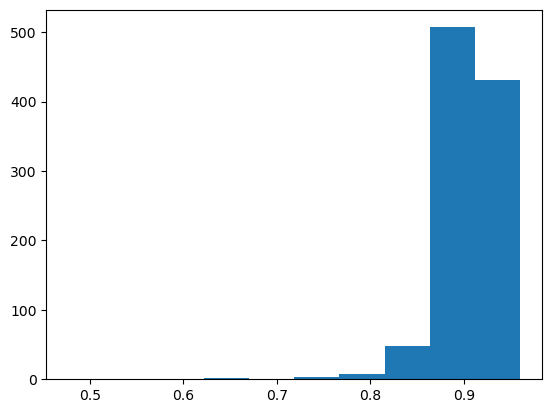

95.0 confidence interval 84.4% and 94.4%


In [74]:
from matplotlib import pyplot
pyplot.hist(stats)
pyplot.show()
# confidence intervals
alpha = 0.95                             # for 95% confidence 
p = ((1.0-alpha)/2.0) * 100              # tail regions on right and left .25 on each side indicated by P value (border)
lower = max(0.0, np.percentile(stats, p))  
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

The model which I would choose to predict the price of the car is Gradient Boosting regressor with 84.4% to 94.4% confidence interval

<h2>Conclusion:</h2>

* The features are selected after normalising the data using zscore and important features are choosen using Decsion tree Regressor.
* The random forest yields overfit model and the k fold cross validation proves the hypothesis
* The gradient boost regressor also results in similar accuracy but the model seems to be good due to similarity in accuracy.
* The ADA boost regressor results in less accurate model with likelihood of overfitting
* The MLR regressor by choosing all the features gave around 92% with likelihood of model overfit.

**From the above results we can conclude the model which is best suited for prediction of car price is Gradient boost Regressor**

- After bootstrap sampling the confidence interval of the GRB model yielded around 84.4% to 94.4%.